In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [4]:
# attenzione: ricordati poi di premoltiplicare per il parametro, se c'è
def Diffusion_a(numPoints, points): # vettore unitario che moltiplica il primo integrale
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data

def Reaction_b(numPoints, points): # vettore unitario che moltiplica il secondo integrale
	values_b = np.ones(numPoints, order='F')
	return values_b.ctypes.data

def Reaction_non_linear_b(numPoints, points, u, u_x, u_y): # vettore con exp(mu_1*u) valutato nei punti di quadratura(?)
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data

def Term_non_linear_der_f_1(numPoints, points, u, u_x, u_y): # f_1 (è uguale al Lab 12)
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data

def Term_non_linear_f_2(numPoints, points, u, u_x, u_y): # f_2
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data

def Term_non_linear_f_4(numPoints, points): # f_4 (parte con la g)
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 100 * np.sin(2*np.pi*matPoints[0,:]) * np.cos(2*np.pi*matPoints[1,:])
	return values_f.ctypes.data

"""
def Burger_exactSolution(numPoints, points):
    # Converte i punti in una matrice 3 x numPoints
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    x = matPoints[0, :]
    y = matPoints[1, :]

    # Risolvi l'equazione quadratica per trovare C
    # C = 100 * mu0 / (mu0 + 8π² C) → (8π²)C² + mu0*C - 100*mu0 = 0
    pi2 = np.pi ** 2
    a = 8 * pi2
    b = mu_0
    c = -100 * mu_0
    C = (-b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)  # Prendiamo la radice positiva

    # Calcola la soluzione esatta
    u = (1.0 / mu_1) * np.log(1.0 + (mu_1 / mu_0) * C * np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y))

    return u.ctypes.data
"""

"""
def Burger_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data
"""
def Ones_f_2(numPoints, points): # serve per f_2
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def Ones_f_3(numPoints, points): # serve per f_3
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def OnesDerivative_f_1(numPoints, points): # serve per f_1
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data
"""
def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data
"""

"\ndef Zeros(numPoints, points):\n\tvalues_zero = np.zeros(numPoints, order='F')\n\treturn values_zero.ctypes.data\n\ndef ZerosDerivative(direction, numPoints, points):\n\tvalues_zero_d = np.zeros(numPoints, order='F')\n\treturn values_zero_d.ctypes.data\n"

In [5]:
meshSize = 0.01
order = 1

domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

In [6]:
residual_norm = 1.0
solution_norm = 1.0;
newton_tol = 1.0e-6
max_iterations = 100 # eventualmente, modifica
num_iteration = 1

In [7]:
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [8]:
mu_set = np.random.uniform(low=0., high=1, size=(100,2))

In [9]:
for mu in mu_set:
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_errorL2 = 5
    u_normL2 = 1
    u_errorH1 = 5
    u_normH1 = 1
    
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)
    
        forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_non_linear_f_4, problemData, lib)
        forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)
        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)
    
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        
        u_k = u_k + du
    
        """
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_errorL2 = gedim.ComputeErrorL2(Burger_exactSolution, u_k, u_strong, lib)
        u_errorH1 = gedim.ComputeErrorH1(Burger_exactDerivativeSolution, u_k, u_strong, lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        """
        solution_norm = 0 # u_normL2;
        residual_norm = 0 # du_normL2;
        
        print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
        print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(u_errorL2 / u_normL2), '{:.16e}'.format(u_errorH1 / u_normH1), '{:.16e}'.format(residual_norm / u_normL2), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations)) 
        
        num_iteration = num_iteration + 1

dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 5.0000000000000000e+00 5.0000000000000000e+00 0.0000000000000000e+00 1 100


/tmp/ipykernel_1812/1430935617.py:18: RuntimeWarning: invalid value encountered in scalar divide
  rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4


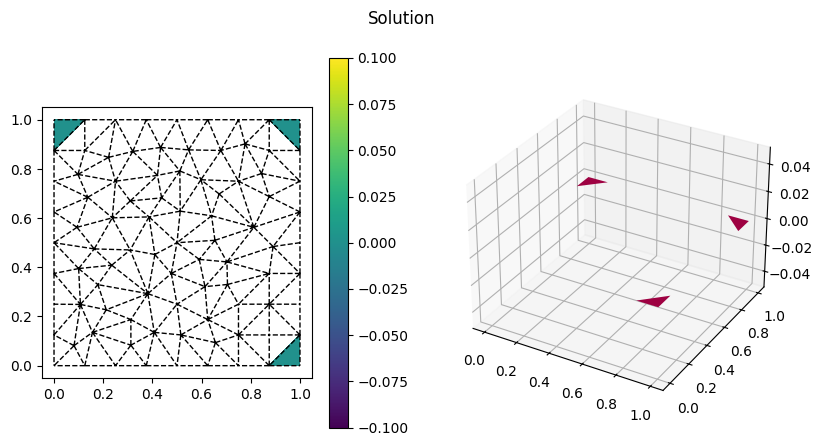

In [10]:
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)